In [29]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pydicom
import albumentations as A
from sklearn.model_selection import train_test_split
from skimage.metrics import structural_similarity as ssim
import logging
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.applications.densenet import preprocess_input
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix


In [30]:
# 1. Configuration & journaux
logging.basicConfig(filename='image_errors.log', level=logging.WARNING,
                    format='%(asctime)s - %(levelname)s - %(message)s')

data_path = '../data/raw'
raw_csv = os.path.join(data_path, 'data_Entry_2017.csv')
clean_csv = os.path.join(data_path, 'cleaned_data.csv')
images_dir = os.path.join(data_path, 'images')
dicom_dir = os.path.join(data_path, 'dicom')

IMG_SIZE = (224, 224)

In [31]:
# 2. Chargement du CSV
try:
    df = pd.read_csv(raw_csv)
except Exception as e:
    logging.error(f"Erreur lors du chargement du CSV : {e}")
    raise

In [32]:
# 3. Nettoyage approfondi
df.columns = df.columns.str.strip()
df = df[['Image Index', 'Finding Labels', 'Patient Age', 'Patient Gender', 'Patient ID']]

# Suppression doublons
df.drop_duplicates(subset=['Image Index'], inplace=True)

# Gestion des valeurs manquantes
df.dropna(subset=['Finding Labels', 'Patient ID'], inplace=True)

# Correction types
df['Patient Age'] = pd.to_numeric(df['Patient Age'], errors='coerce')
df['Patient Gender'] = df['Patient Gender'].astype(str).str.upper().str.strip()

# Filtrage logique
df = df[(df['Patient Age'] > 0) & (df['Patient Age'] < 120)]
df = df[df['Patient Gender'].isin(['M','F'])]

# Nettoyage labels
df['Finding Labels'] = df['Finding Labels'].str.replace('No Finding','Normal')
df['Finding Labels'] = df['Finding Labels'].str.replace(r'\|+', '|', regex=True)
df['Finding Labels'] = df['Finding Labels'].str.strip()

# Vérification images existantes
existing_files = set(os.listdir(images_dir))
df = df[df['Image Index'].isin(existing_files)]

print(f"Nombre total d’entrées nettoyées : {len(df)}")
print(f"Âge moyen : {df['Patient Age'].mean():.2f}")
print("Répartition du genre :")
print(df['Patient Gender'].value_counts())


Nombre total d’entrées nettoyées : 4999
Âge moyen : 51.81
Répartition du genre :
Patient Gender
M    2608
F    2391
Name: count, dtype: int64


In [33]:
# 4. Conversion labels en colonnes binaires
pathologies = ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration',
               'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation',
               'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia', 'Normal']

for p in pathologies:
    df[p] = df['Finding Labels'].apply(lambda x: 1 if p in x else 0)

rare_diseases = [p for p in pathologies if df[p].sum() < 20]
if rare_diseases:
    df.drop(columns=rare_diseases, inplace=True)
    pathologies = [p for p in pathologies if p not in rare_diseases]
    print(f"Pathologies rares supprimées : {rare_diseases}")

# Sauvegarde CSV nettoyé
df.to_csv(clean_csv, index=False)
print(f" CSV nettoyé sauvegardé : {clean_csv}")


 CSV nettoyé sauvegardé : ../data/raw\cleaned_data.csv


In [35]:
# 5. Chargement et prétraitement images
def load_image(img_name, size=IMG_SIZE, dicom=False):
    try:
        if dicom:
            path = os.path.join(dicom_dir, img_name)
            ds = pydicom.dcmread(path)
            img = ds.pixel_array.astype(np.float32)
            img = np.clip(img, 0, 2000)/2000.0
            img = cv2.resize(img, size)
        else:
            path = os.path.join(images_dir, img_name)
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                raise FileNotFoundError(f"Image non trouvée : {img_name}")
            img = cv2.resize(img, size)
            img = img.astype(np.float32)/255.0
        return img
    except Exception as e:
        logging.warning(f"{img_name} : {e}")
        return None

augmentations = A.Compose([
    A.Rotate(limit=10, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.Blur(p=0.2)
])

max_images = 5000
X_list, y_list, valid_images = [], [], []

for img_name in df['Image Index'].head(max_images):
    img = load_image(img_name)
    if img is not None:
        img_aug = augmentations(image=img)['image']
        try:
            ssim_value = ssim(img, img_aug, data_range=1.0)
            if ssim_value < 0.85:
                logging.warning(f"SSIM faible pour {img_name}: {ssim_value:.3f}")
        except Exception as e:
            logging.error(f"Erreur SSIM pour {img_name}: {e}")
        X_list.append(img_aug[..., np.newaxis])
        y_list.append(df[df['Image Index']==img_name][pathologies].values[0])
        valid_images.append(img_name)

X = np.array(X_list)
y = np.array(y_list)
print(f"Images valides : {len(valid_images)}, X={X.shape}, y={y.shape}")


Images valides : 4999, X=(4999, 224, 224, 1), y=(4999, 15)


In [36]:
# 6. Split patient-wise

df_valid = df[df['Image Index'].isin(valid_images)].reset_index(drop=True)
unique_patients = df_valid['Patient ID'].unique()
train_patients, test_patients = train_test_split(unique_patients, test_size=0.2, random_state=42)

train_idx = df_valid['Patient ID'].isin(train_patients)
test_idx = df_valid['Patient ID'].isin(test_patients)

X_train, X_test = X[train_idx.values], X[test_idx.values]
y_train, y_test = y[train_idx.values], y[test_idx.values]

print(f"Train: {X_train.shape[0]} images, Test: {X_test.shape[0]} images")


Train: 4005 images, Test: 994 images


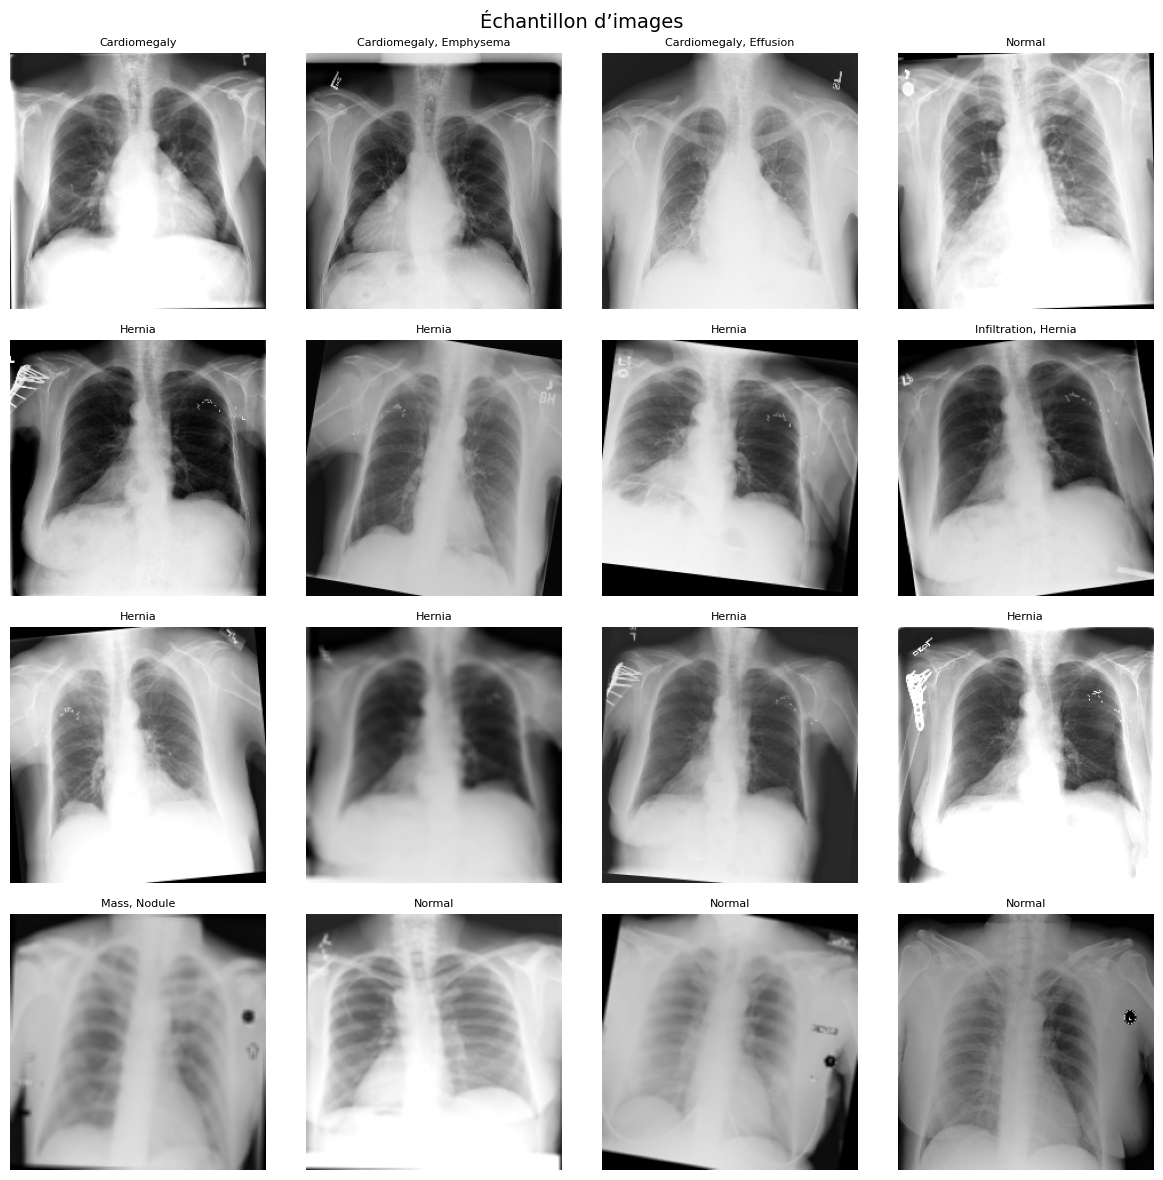

In [37]:
# 7. Visualisation
plt.figure(figsize=(12,12))
n_images = min(16, X_train.shape[0])
for i in range(n_images):
    plt.subplot(4,4,i+1)
    try:
        plt.imshow(X_train[i,:,:,0], cmap='gray', vmin=0, vmax=1)
        labels = [p for p,val in zip(pathologies, y_train[i]) if val==1]
        plt.title(", ".join(labels) if labels else "Normal", fontsize=8)
        plt.axis('off')
    except Exception as e:
        logging.error(f"Erreur visuel {i}: {e}")
        plt.axis('off')
plt.suptitle("Échantillon d’images", fontsize=14)
plt.tight_layout()
plt.savefig('visualization_output.png', dpi=300, bbox_inches='tight')
plt.show()


In [38]:
# 8. Préparation DenseNet121
X_train_rgb = np.repeat(X_train, 3, axis=-1)
X_test_rgb = np.repeat(X_test, 3, axis=-1)

X_train_rgb = preprocess_input(X_train_rgb)
X_test_rgb = preprocess_input(X_test_rgb)

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224,224,3))
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(len(pathologies), activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_4    │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_4… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_5    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_5… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,052,879 (26.90 MB)

 Trainable params: 15,375 (60.06 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [39]:
# 9. Entraînement

history = model.fit(
    X_train_rgb, y_train,
    validation_data=(X_test_rgb, y_test),
    epochs=10,
    batch_size=32
)

Epoch 1/10
 73/126 ━━━━━━━━━━━━━━━━━━━━ 2:12 3s/step - accuracy: 0.2705 - loss: 0.4132

KeyboardInterrupt: 

In [ ]:
# 10. Évaluation et sauvegarde
loss, acc = model.evaluate(X_test_rgb, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {acc:.4f}")
model.save('densenet_multilabel_model.h5')
print(" Modèle DenseNet121 sauvegardé !")

A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of 30ee3e1110167f948a6b9946edeeb738 so we will re-download the data.
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,052,879 (26.90 MB)

 Trainable params: 15,375 (60.06 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [40]:
# 11. Entraînement du modèle
history = model.fit(
    X_train_rgb, y_train,
    validation_data=(X_test_rgb, y_test),
    epochs=10,
    batch_size=32
)

Epoch 1/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 378s 3s/step - accuracy: 0.5568 - loss: 0.2111 - val_accuracy: 0.5272 - val_loss: 0.2247
Epoch 2/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 303s 2s/step - accuracy: 0.5568 - loss: 0.2107 - val_accuracy: 0.5272 - val_loss: 0.2250
Epoch 3/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 270s 2s/step - accuracy: 0.5568 - loss: 0.2104 - val_accuracy: 0.5272 - val_loss: 0.2258
Epoch 4/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 290s 2s/step - accuracy: 0.5568 - loss: 0.2102 - val_accuracy: 0.5272 - val_loss: 0.2249
Epoch 5/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 290s 2s/step - accuracy: 0.5568 - loss: 0.2103 - val_accuracy: 0.5272 - val_loss: 0.2257
Epoch 6/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 290s 2s/step - accuracy: 0.5568 - loss: 0.2101 - val_accuracy: 0.5272 - val_loss: 0.2243
Epoch 7/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 291s 2s/step - accuracy: 0.5568 - loss: 0.2099 - val_accuracy: 0.5272 - val_loss: 0.2235
Epoch 8/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 290s 2s/step - accuracy: 0.5568 - loss: 0.2097 - val_accu

In [42]:
# 12. Évaluation et sauvegarde

# Évaluation sur le jeu de test
loss, acc = model.evaluate(X_test_rgb, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {acc:.4f}")

# Sauvegarde du modèle
model.save('densenet_multilabel_model.h5')
print(" Modèle DenseNet121 sauvegardé ")

32/32 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.5272 - loss: 0.2225
Test Loss: 0.2225, Test Accuracy: 0.5272
 Modèle DenseNet121 sauvegardé 


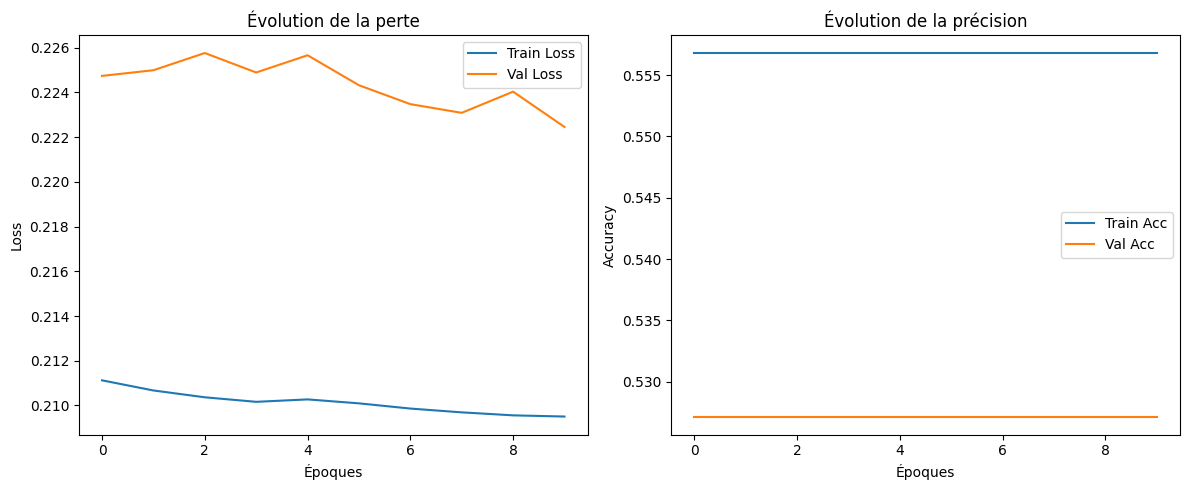

32/32 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step
Rapport de classification :
                    precision    recall  f1-score   support

       Atelectasis       0.00      0.00      0.00        82
      Cardiomegaly       0.00      0.00      0.00        75
          Effusion       0.00      0.00      0.00       127
      Infiltration       0.00      0.00      0.00       153
              Mass       0.00      0.00      0.00        39
            Nodule       0.00      0.00      0.00        54
         Pneumonia       0.00      0.00      0.00        11
      Pneumothorax       0.00      0.00      0.00        18
     Consolidation       0.00      0.00      0.00        44
             Edema       0.00      0.00      0.00        34
         Emphysema       0.00      0.00      0.00        18
          Fibrosis       0.00      0.00      0.00        31
Pleural_Thickening       0.00      0.00      0.00        39
            Hernia       0.00      0.00      0.00         0
            Normal       0.58   

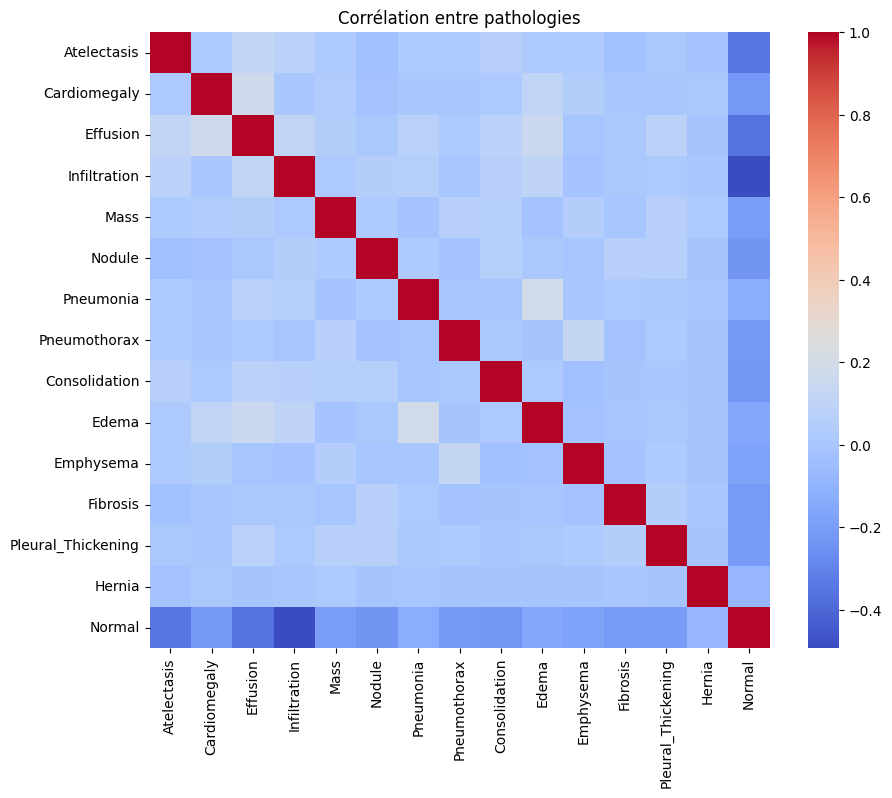

In [43]:
# 13. Analyse des performances


# Courbes d'apprentissage
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Évolution de la perte')
plt.xlabel('Époques')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Évolution de la précision')
plt.xlabel('Époques')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Rapport de classification multilabel (seuil = 0.5)
y_pred = (model.predict(X_test_rgb) > 0.5).astype(int)

print("Rapport de classification :")
print(classification_report(y_test, y_pred, target_names=pathologies, zero_division=0))

# Corrélation entre pathologies (co-occurrences)
corr = df[pathologies].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title("Corrélation entre pathologies")
plt.show()


Atelectasis          | Sensibilité: 0.000 | Spécificité: 1.000
Cardiomegaly         | Sensibilité: 0.000 | Spécificité: 1.000
Effusion             | Sensibilité: 0.000 | Spécificité: 1.000
Infiltration         | Sensibilité: 0.000 | Spécificité: 1.000
Mass                 | Sensibilité: 0.000 | Spécificité: 1.000
Nodule               | Sensibilité: 0.000 | Spécificité: 1.000
Pneumonia            | Sensibilité: 0.000 | Spécificité: 1.000
Pneumothorax         | Sensibilité: 0.000 | Spécificité: 1.000
Consolidation        | Sensibilité: 0.000 | Spécificité: 1.000
Edema                | Sensibilité: 0.000 | Spécificité: 1.000
Emphysema            | Sensibilité: 0.000 | Spécificité: 1.000
Fibrosis             | Sensibilité: 0.000 | Spécificité: 1.000
Pleural_Thickening   | Sensibilité: 0.000 | Spécificité: 1.000
Hernia               | Sensibilité: 0.000 | Spécificité: 1.000
Normal               | Sensibilité: 0.884 | Spécificité: 0.283


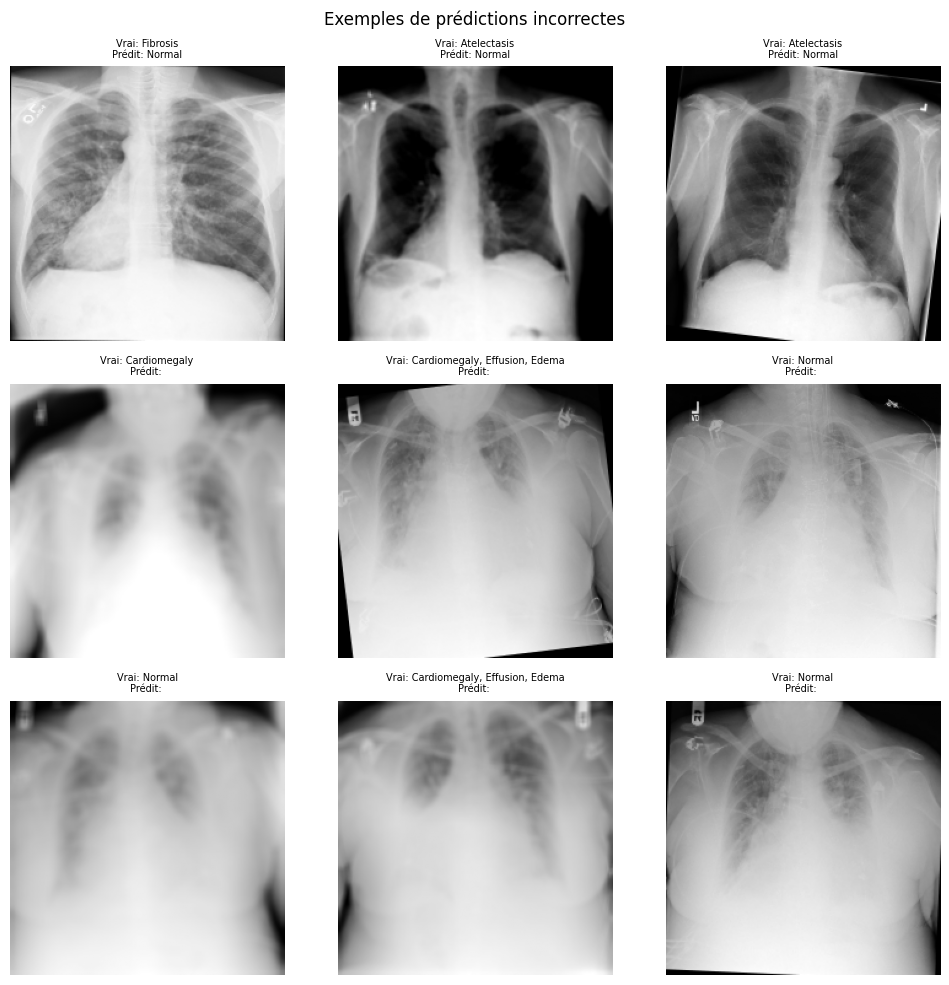


 Pistes d'amélioration possibles :
- Augmenter la taille du dataset (images supplémentaires, rotations, contrastes)
- Dégeler certaines couches du DenseNet pour le fine-tuning
- Ajuster les poids des classes (déséquilibre entre pathologies)
- Tester d'autres architectures : EfficientNet, ResNet50, etc.
- Utiliser des métriques adaptées au multilabel (AUC, F1-macro)


In [44]:
# 14. Interprétation et pistes d'amélioration

# Matrice de confusion multilabel
mcm = multilabel_confusion_matrix(y_test, y_pred)

for i, p in enumerate(pathologies):
    tn, fp, fn, tp = mcm[i].ravel()
    sensitivity = tp / (tp + fn + 1e-6)
    specificity = tn / (tn + fp + 1e-6)
    print(f"{p:20s} | Sensibilité: {sensitivity:.3f} | Spécificité: {specificity:.3f}")

# Visualisation de quelques erreurs
incorrect_idx = np.where(np.sum(np.abs(y_pred - y_test), axis=1) > 0)[0][:9]

plt.figure(figsize=(10,10))
for i, idx in enumerate(incorrect_idx):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[idx,:,:,0], cmap='gray')
    true_labels = [p for p,v in zip(pathologies, y_test[idx]) if v==1]
    pred_labels = [p for p,v in zip(pathologies, y_pred[idx]) if v==1]
    plt.title(f"Vrai: {', '.join(true_labels)}\nPrédit: {', '.join(pred_labels)}", fontsize=7)
    plt.axis('off')
plt.suptitle("Exemples de prédictions incorrectes", fontsize=12)
plt.tight_layout()
plt.show()

# Pistes d'amélioration
print("\n Pistes d'amélioration possibles :")
print("- Augmenter la taille du dataset (images supplémentaires, rotations, contrastes)")
print("- Dégeler certaines couches du DenseNet pour le fine-tuning")
print("- Ajuster les poids des classes (déséquilibre entre pathologies)")
print("- Tester d'autres architectures : EfficientNet, ResNet50, etc.")
print("- Utiliser des métriques adaptées au multilabel (AUC, F1-macro)")


In [45]:
# 15. Fine-tuning du modèle DenseNet121

# On dégèle une partie des couches profondes pour affiner les poids
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Recompiler avec un taux d'apprentissage plus faible
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Réentraînement (fine-tuning)
fine_tune_history = model.fit(
    X_train_rgb, y_train,
    validation_data=(X_test_rgb, y_test),
    epochs=5,
    batch_size=16
)

# Sauvegarde du modèle affiné
model.save('densenet_finetuned_model.h5')
print("Modèle DenseNet121 affiné et sauvegardé !")

# Évaluation post fine-tuning
fine_loss, fine_acc = model.evaluate(X_test_rgb, y_test)
print(f"Test Loss (fine-tuned): {fine_loss:.4f}, Test Accuracy: {fine_acc:.4f}")


Epoch 1/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 357s 1s/step - accuracy: 0.5568 - loss: 0.4958 - val_accuracy: 0.5272 - val_loss: 0.3402
Epoch 2/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 331s 1s/step - accuracy: 0.5546 - loss: 0.4263 - val_accuracy: 0.5231 - val_loss: 0.3983
Epoch 3/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 332s 1s/step - accuracy: 0.5548 - loss: 0.3881 - val_accuracy: 0.5231 - val_loss: 0.3846
Epoch 4/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 331s 1s/step - accuracy: 0.5551 - loss: 0.3599 - val_accuracy: 0.5151 - val_loss: 0.3584
Epoch 5/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 331s 1s/step - accuracy: 0.5568 - loss: 0.3361 - val_accuracy: 0.5181 - val_loss: 0.3364
Modèle DenseNet121 affiné et sauvegardé !
32/32 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.5181 - loss: 0.3364
Test Loss (fine-tuned): 0.3364, Test Accuracy: 0.5181


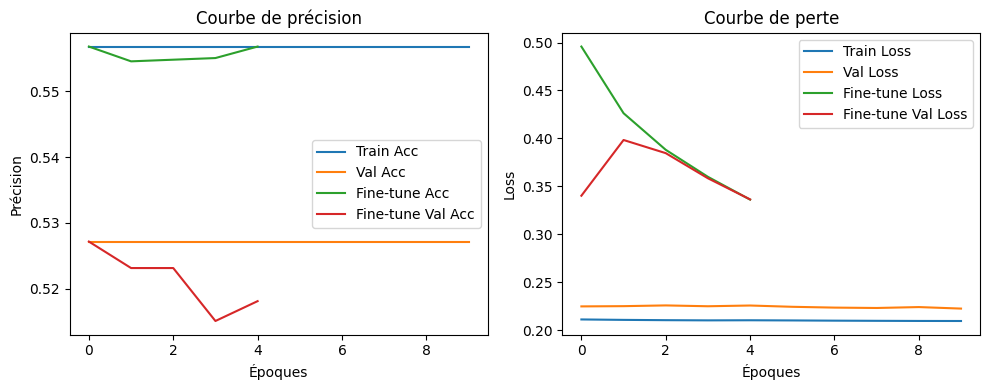

32/32 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step


c:\Users\Asus\Diagnostic-Radiologique\venv\Lib\site-packages\sklearn\metrics\_ranking.py:1201: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


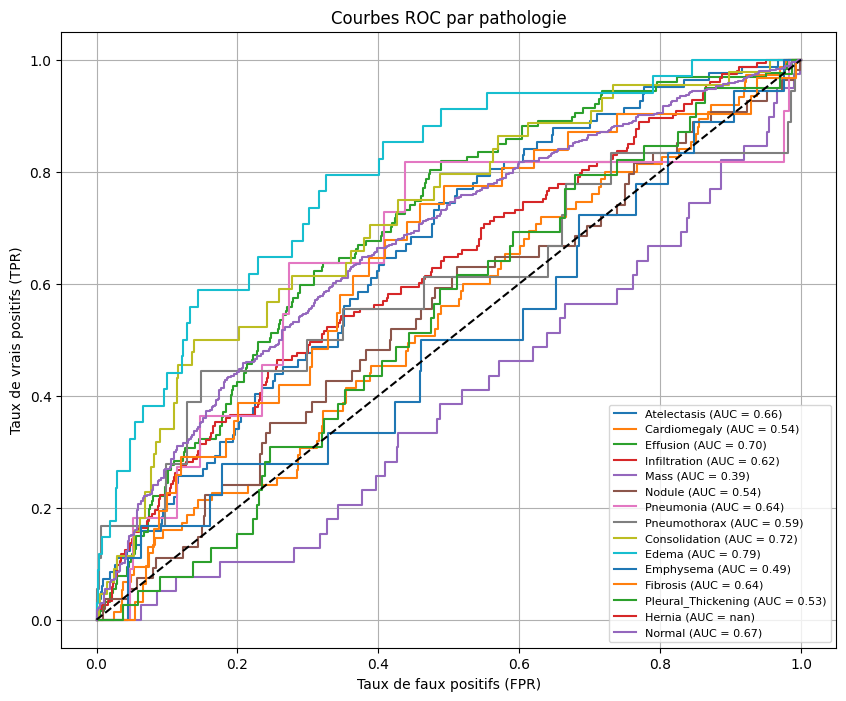

In [46]:
# 16. Visualisation des performances finales
import seaborn as sns
from sklearn.metrics import roc_curve, auc, roc_auc_score

#  Courbes d'apprentissage
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.plot(fine_tune_history.history['accuracy'], label='Fine-tune Acc')
plt.plot(fine_tune_history.history['val_accuracy'], label='Fine-tune Val Acc')
plt.title("Courbe de précision")
plt.xlabel("Époques")
plt.ylabel("Précision")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.plot(fine_tune_history.history['loss'], label='Fine-tune Loss')
plt.plot(fine_tune_history.history['val_loss'], label='Fine-tune Val Loss')
plt.title("Courbe de perte")
plt.xlabel("Époques")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# ROC-AUC pour chaque pathologie
y_pred = model.predict(X_test_rgb)
plt.figure(figsize=(10, 8))
for i, pathology in enumerate(pathologies):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{pathology} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('Courbes ROC par pathologie')
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.legend(fontsize=8)
plt.grid(True)
plt.show()


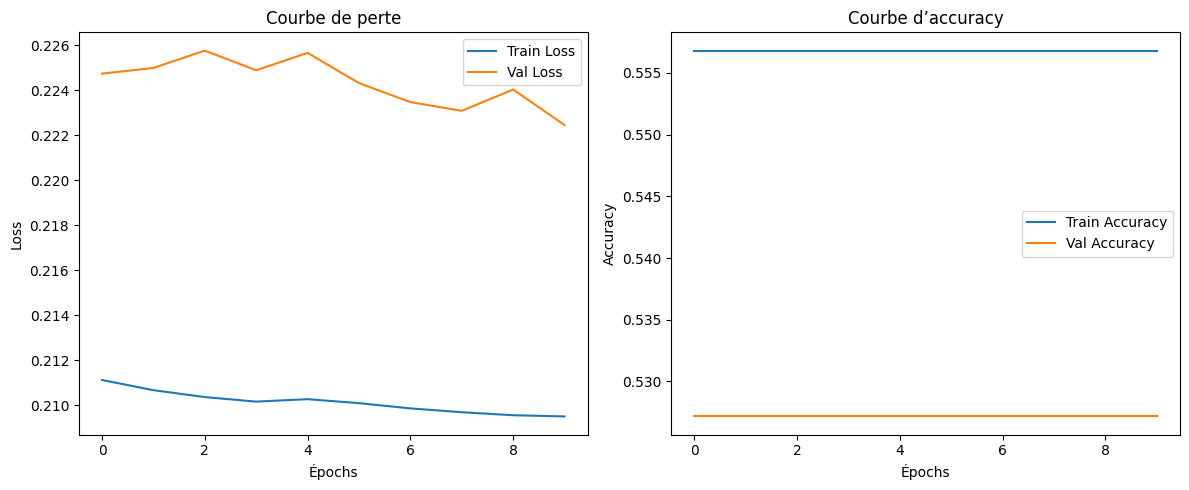

32/32 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step
--- Atelectasis ---
[[912   0]
 [ 82   0]] 

--- Cardiomegaly ---
[[919   0]
 [ 75   0]] 

--- Effusion ---
[[867   0]
 [127   0]] 

--- Infiltration ---
[[840   1]
 [152   1]] 

--- Mass ---
[[955   0]
 [ 39   0]] 

--- Nodule ---
[[940   0]
 [ 54   0]] 

--- Pneumonia ---
[[983   0]
 [ 11   0]] 

--- Pneumothorax ---
[[976   0]
 [ 18   0]] 

--- Consolidation ---
[[950   0]
 [ 44   0]] 

--- Edema ---
[[960   0]
 [ 34   0]] 

--- Emphysema ---
[[976   0]
 [ 18   0]] 

--- Fibrosis ---
[[963   0]
 [ 31   0]] 

--- Pleural_Thickening ---
[[955   0]
 [ 39   0]] 

--- Hernia ---
[[994   0]
 [  0   0]] 

--- Normal ---
[[256 214]
 [160 364]] 


=== Classification Report ===

                    precision    recall  f1-score   support

       Atelectasis       0.00      0.00      0.00        82
      Cardiomegaly       0.00      0.00      0.00        75
          Effusion       0.00      0.00      0.00       127
      Infiltration       0.50      0.01

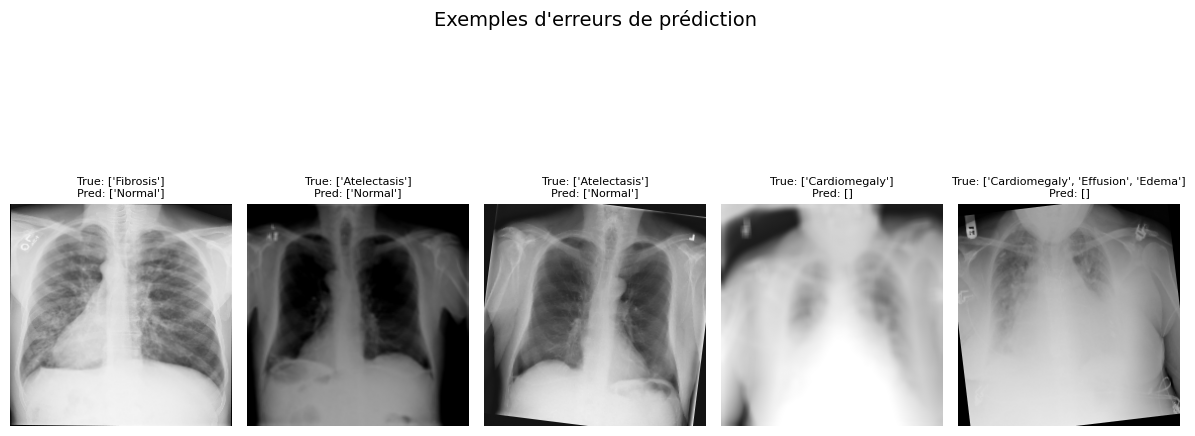

In [47]:
# 17. Visualisation et analyse des performances
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix, classification_report
import numpy as np

# Courbes d'entraînement et validation
plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Courbe de perte')
plt.xlabel('Épochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Courbe d’accuracy')
plt.xlabel('Épochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Prédictions sur le jeu de test
y_pred = (model.predict(X_test_rgb) > 0.5).astype(int)

# Matrices de confusion multilabel
mcm = multilabel_confusion_matrix(y_test, y_pred)
for i, p in enumerate(pathologies):
    print(f"--- {p} ---")
    print(mcm[i], "\n")

# Classification report pour chaque pathologie
report = classification_report(y_test, y_pred, target_names=pathologies, zero_division=0)
print("\n=== Classification Report ===\n")
print(report)

# Analyse qualitative : affichage des erreurs
n_errors = 5
error_idx = np.where((y_test != y_pred).any(axis=1))[0]

plt.figure(figsize=(12,6))
for i, idx in enumerate(error_idx[:n_errors]):
    plt.subplot(1,n_errors,i+1)
    plt.imshow(X_test[idx,:,:,0], cmap='gray', vmin=0, vmax=1)
    true_labels = [p for p, val in zip(pathologies, y_test[idx]) if val==1]
    pred_labels = [p for p, val in zip(pathologies, y_pred[idx]) if val==1]
    plt.title(f"True: {true_labels}\nPred: {pred_labels}", fontsize=8)
    plt.axis('off')
plt.suptitle("Exemples d'erreurs de prédiction", fontsize=14)
plt.tight_layout()
plt.show()

In [48]:
# 18. Sauvegarde des résultats analytiques
results_path = os.path.join(data_path, 'model_analysis')
os.makedirs(results_path, exist_ok=True)

# Sauvegarde du rapport classification
report_file = os.path.join(results_path, 'classification_report.txt')
with open(report_file, 'w') as f:
    f.write(report)
print(f"\n Rapport de classification sauvegardé : {report_file}")

# Sauvegarde des matrices de confusion
for i, p in enumerate(pathologies):
    np.savetxt(os.path.join(results_path, f"confusion_matrix_{p}.txt"), mcm[i], fmt='%d')
print(f" Matrices de confusion sauvegardées dans {results_path}")


 Rapport de classification sauvegardé : ../data/raw\model_analysis\classification_report.txt
 Matrices de confusion sauvegardées dans ../data/raw\model_analysis
